In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../scripts')

import stft_zoom, display, detect_musical_regions
from util import *
import mappings
import pickle
import PIL
import IPython.display
from classes import SingleResSpectrogram, MultiResSpectrogram
from aug_density_map import *
from mappings import *

/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
import detect_musical_regions

In [3]:
y, sr = librosa.load('../../midi-experiment/notebooks/testee.wav', sr=44100)
model_800 = pickle.load(open('./renyi_shannon_prollharm_800.sav', 'rb'))

In [4]:
n_fft = 512
hop_size = 128
kernel = [1000,1000]

model_200 = pickle.load(open('./renyi_shannon_prollharm_200.sav', 'rb'))
model_500 = pickle.load(open('./renyi_shannon_prollharm_500.sav', 'rb'))
model_800 = pickle.load(open('./renyi_shannon_prollharm_800.sav', 'rb'))

In [56]:
def our_solution(y, res, kernel, model, pct, sr=44100, n_fft=512, hop_size=128):
    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
    time_span = [0,len(y)/sr]
    x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 
    base_spec = SingleResSpectrogram(spec, x_axis, y_axis)
    multires_spec = MultiResSpectrogram(base_spec)

    indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, kernel=kernel, mode='pct', pct_or_threshold=pct, n_fft=n_fft, hop_size=hop_size)
    to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)

    stft_zoom.set_signal_bank(y,kernel)

    for subregion in to_be_refined:
        freq_range = subregion[0]
        time_range = subregion[1]
        spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=res)
        refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis)
        multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1)
        
    return multires_spec

In [6]:
multires_spec = our_solution(y, 5, kernel, model_800)

In [7]:
multires_vis = multires_spec.generate_visualization()
spec = np.abs(librosa.stft(y, n_fft=512))

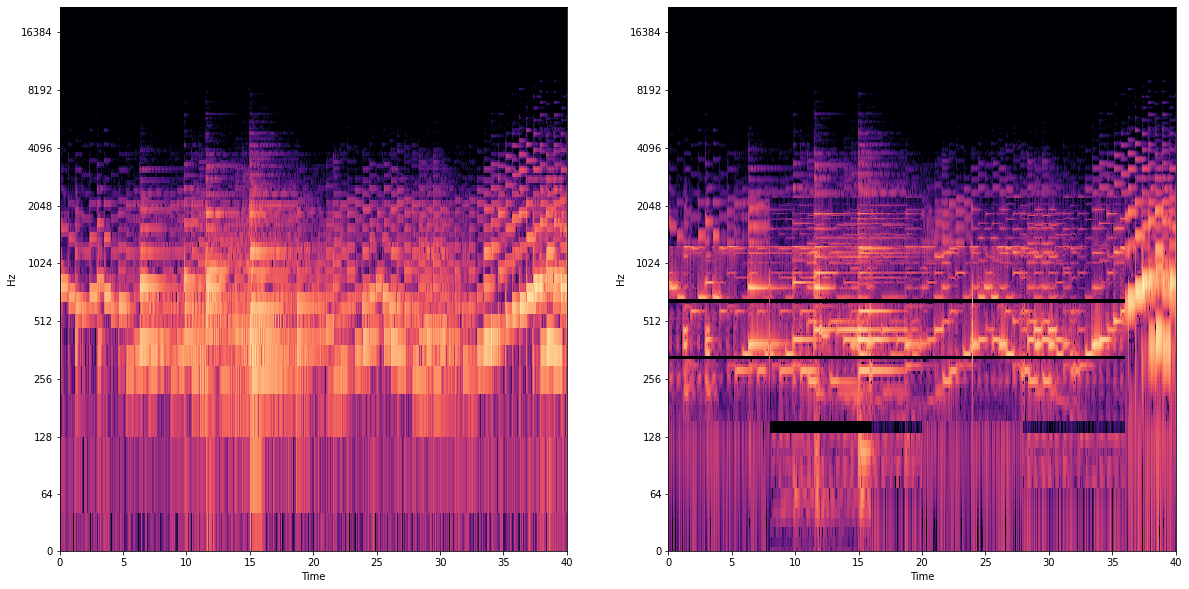

In [8]:
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(multires_vis, ref=np.max), y_axis='log', x_axis='time', sr=sr)

### Agora, 2 ou mais níveis

In [45]:
def our_solution_multilevel(y, res, kernel_list, model, pct_list, sr=44100, n_fft=512, hop_size=128):
    spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size))
    time_span = [0,len(y)/sr]
    x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, time_span, spec.shape) 
    base_spec = SingleResSpectrogram(spec, x_axis, y_axis)
    multires_spec = MultiResSpectrogram(base_spec)
    
    kernel = kernel_list[0]
    indices, original_shape = detect_musical_regions.detect_musical_regions(model, spec, kernel=kernel, mode='pct', pct_or_threshold=pct_list[0], n_fft=n_fft, hop_size=hop_size)
    to_be_refined = detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, n_fft=n_fft, hop_size=hop_size)

    stft_zoom.set_signal_bank(y,kernel)

    for subregion in to_be_refined:
        freq_range = subregion[0]
        time_range = subregion[1]
        spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=res)
        refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
        multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1)
        
    i = 1
    k = res
    for kernel in kernel_list[1:]:
#         print(kernel)
        i += 1
        if i == 2:
            spec_list = multires_spec.first_zoom
        elif i == 3:
            spec_list = multires_spec.second_zoom
        elif i == 4:
            spec_list = multires_spec.third_zoom

        to_be_further_refined = []
        for spec_zoom in spec_list:
            spec        = np.array(spec_zoom.spec, dtype=float)
            x_axis      = spec_zoom.x_axis
            y_axis      = spec_zoom.y_axis
            sr          = spec_zoom.sr
            window_size = spec_zoom.n_fft
            hop_size    = spec_zoom.hop_size

            indices, original_shape = detect_musical_regions.detect_musical_regions(model_200, spec, mode='pct', pct_or_threshold=pct_list[i-1], kernel=kernel, n_fft=window_size, hop_size=hop_size, sr=sr, y_axis=y_axis)
            to_be_further_refined = to_be_further_refined + detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, sr=sr, hop_size=hop_size)

        k=k*3
        sr=44100
        hop_size=128
        n_fft=512
        
#         print(len(to_be_further_refined))
        for subregion in to_be_further_refined:
            freq_range = subregion[0]
            time_range = subregion[1]
#             print(freq_range, time_range)
            spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=k)
            refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
            multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=i, normalize=False)

    return multires_spec

In [52]:
file_name = '../data/MIDI-Unprocessed_XP_09_R1_2004_05_ORIG_MID--AUDIO_09_R1_2004_06_Track06_wav.wav'
y, sr = librosa.load(file_name, sr=44100)
y = y[:44100*30]

In [33]:
multires_spec_1 = our_solution_multilevel(y, 2, [[1600,1600]], model_800)
multires_spec_2 = our_solution_multilevel(y, 2, [[1600,1600], [800,800]], model_800)
multires_spec_3 = our_solution_multilevel(y, 2, [[1600,1600], [800,800], [400,400]], model_800)
multires_spec_4 = our_solution_multilevel(y, 2, [[1600,1600], [800,800], [400,400], [200,200]], model_800)

In [34]:
multires_vis_1 = multires_spec_1.generate_visualization()
multires_vis_2 = multires_spec_2.generate_visualization()
multires_vis_3 = multires_spec_3.generate_visualization()
multires_vis_4 = multires_spec_4.generate_visualization()

In [43]:
spec = np.abs(librosa.stft(y, n_fft=512))

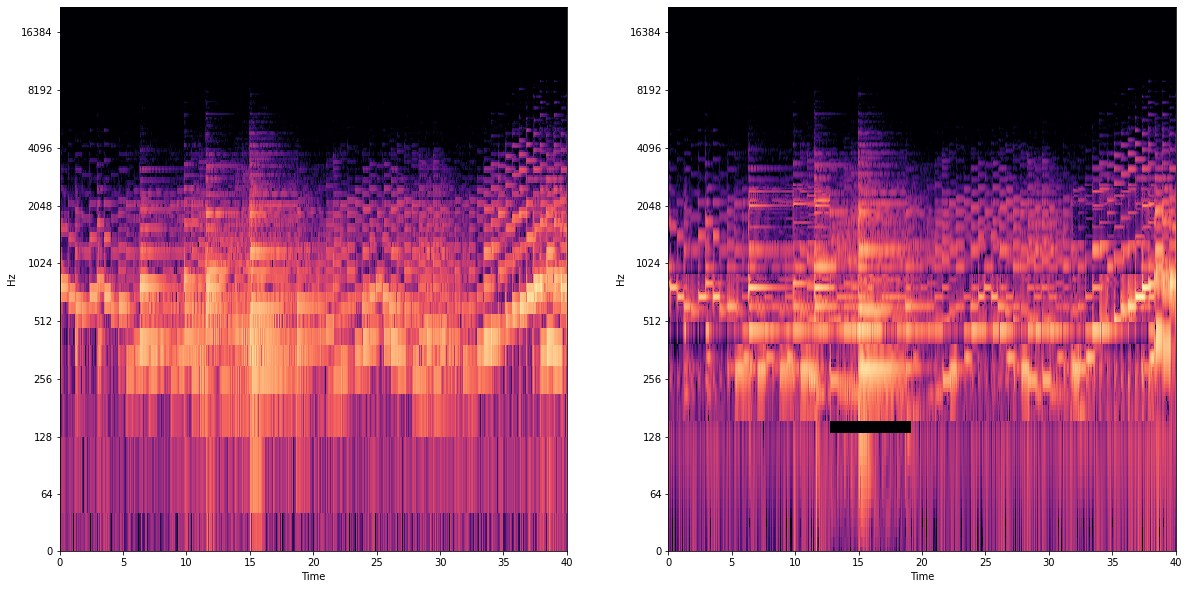

In [44]:
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(multires_vis_1, ref=np.max), y_axis='log', x_axis='time', sr=sr)

In [40]:
IPython.display.Audio(y, rate=sr)

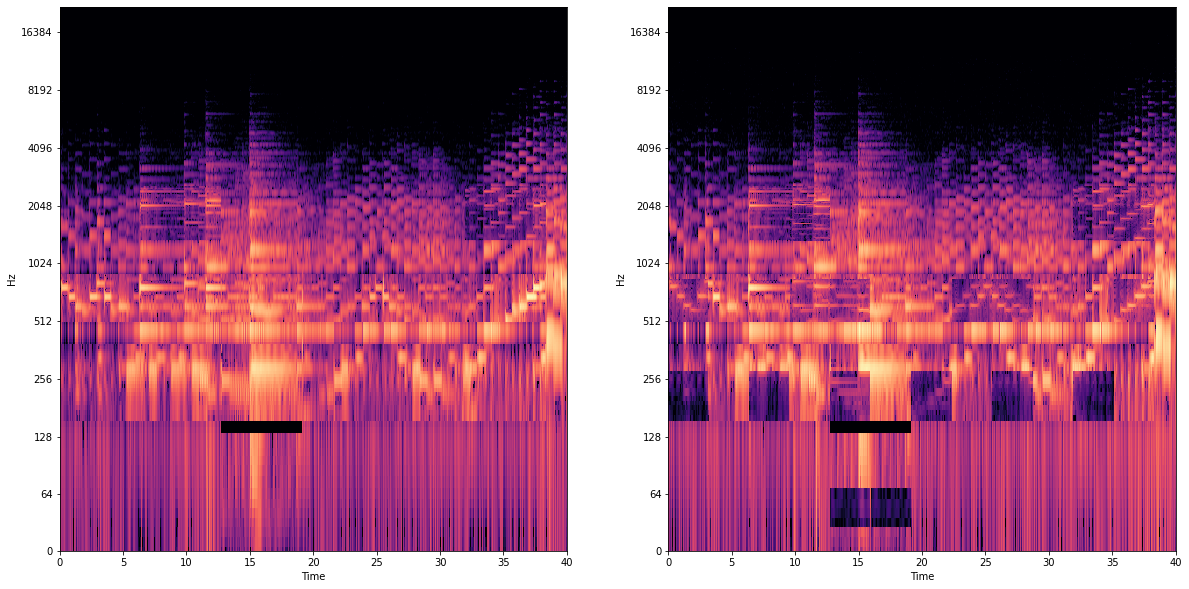

In [37]:
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(multires_vis_1, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(multires_vis_2, ref=np.max), y_axis='log', x_axis='time', sr=sr)

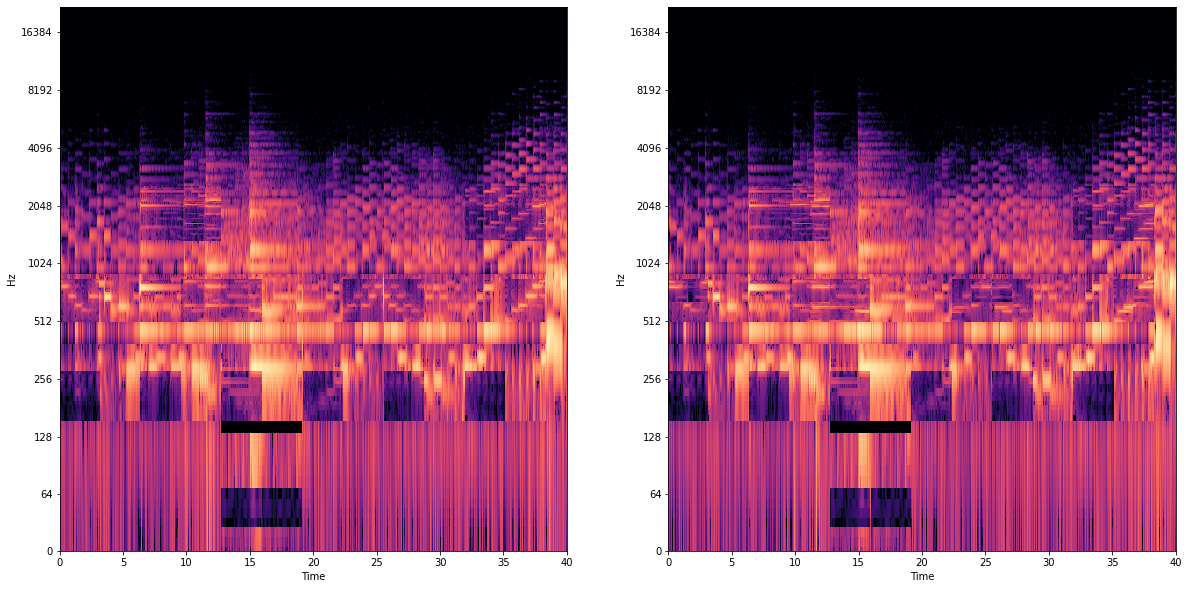

In [38]:
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(multires_vis_2, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(multires_vis_3, ref=np.max), y_axis='log', x_axis='time', sr=sr)

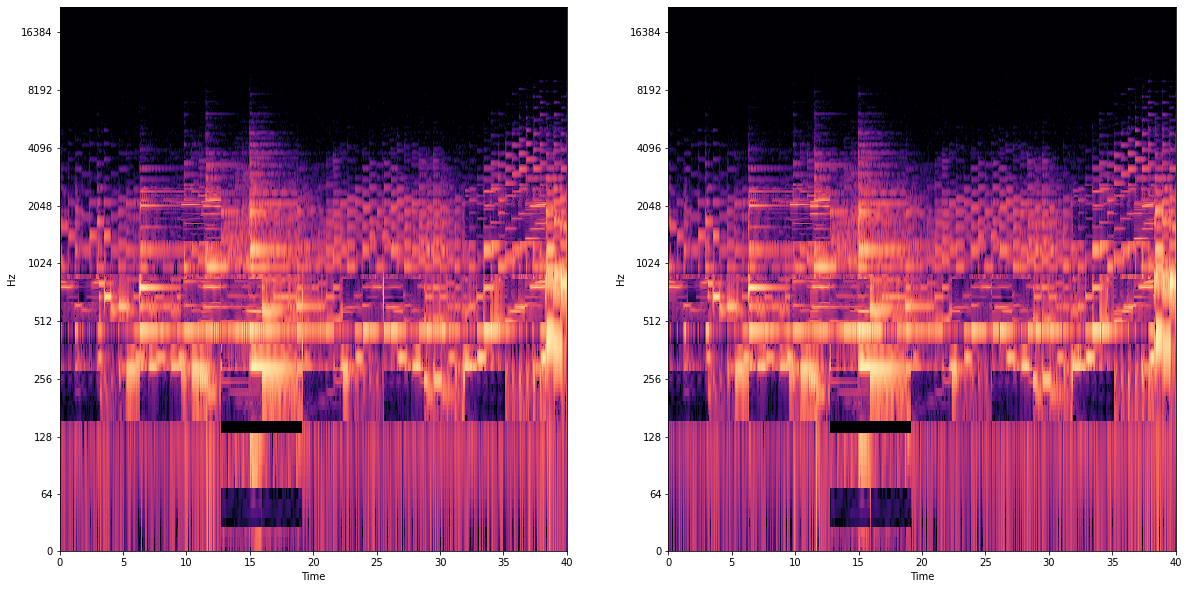

In [39]:
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(multires_vis_3, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(multires_vis_4, ref=np.max), y_axis='log', x_axis='time', sr=sr)

#### Nível 1: kernel 1000x1000, k=2, pct=0.5

In [24]:
# Já feito, guardado em multires_spec

#### Nível 2: kernel 200,200, k=5, pct=0.5

In [25]:
model_200 = pickle.load(open('./renyi_shannon_prollharm_200.sav', 'rb'))

In [26]:
i = 1
for kernel in kernel_list[:1]:
    i += 1
    if i == 2:
        spec_list = multires_spec.first_zoom
    if i == 2:
        spec_list = multires_spec.second_zoom
    if i == 2:
        spec_list = multires_spec.third_zoom

    to_be_further_refined = []
    for spec_zoom in spec_list:
        spec        = np.array(spec_zoom.spec, dtype=float)
        x_axis      = spec_zoom.x_axis
        y_axis      = spec_zoom.y_axis
        sr          = spec_zoom.sr
        window_size = spec_zoom.n_fft
        hop_size    = spec_zoom.hop_size

        indices, original_shape = detect_musical_regions.detect_musical_regions(model_200, spec, mode='pct', pct_or_threshold=25, kernel=kernel, n_fft=window_size, hop_size=hop_size, sr=sr, y_axis=y_axis)
        to_be_further_refined = to_be_further_refined + detect_musical_regions.musical_regions_to_ranges(indices, original_shape, x_axis, y_axis, kernel, sr=sr, hop_size=hop_size)

    k=10
    sr=44100
    hop_size=128
    n_fft=512

    for subregion in to_be_further_refined:
        freq_range = subregion[0]
        time_range = subregion[1]
        spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=k)
        refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
        multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=i, normalize=False)

In [27]:
len(to_be_further_refined)

181

In [28]:
k=10
sr=44100
hop_size=128
n_fft=512

for subregion in to_be_further_refined:
    freq_range = subregion[0]
    time_range = subregion[1]
    spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=k)
    refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis, n_fft=window_size, hop_size=hop_size, sr=new_sr)
    multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=2, normalize=False)

E aí, funcionou?

In [12]:
to_be_refined[0]

([344.53125, 689.0625], [3.0043541364296082, 4.005805515239477])

In [13]:
first_zoom = multires_spec.first_zoom[0]
spec_zoom = np.array(first_zoom.spec, dtype=float)

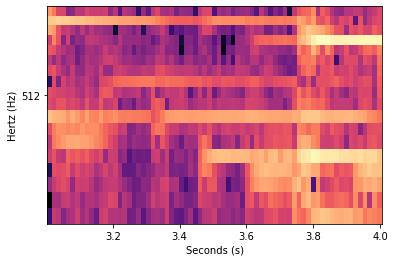

In [14]:
display.specshow(librosa.amplitude_to_db(spec_zoom, ref=np.max), first_zoom.x_axis, first_zoom.y_axis, y_axis='log', x_axis='time')

In [15]:
second_zoom = multires_spec.second_zoom[0]
spec_zoom = np.array(second_zoom.spec, dtype=float)

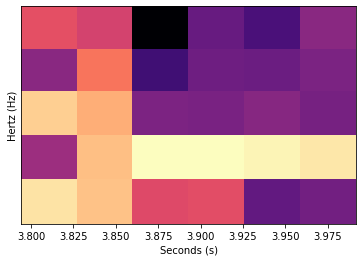

In [16]:
display.specshow(librosa.amplitude_to_db(spec_zoom, ref=np.max), second_zoom.x_axis, second_zoom.y_axis, y_axis='log', x_axis='time')

In [17]:
# pra visualizar: cola por cima os do primeiro zoom, depois os de segundo zoom

In [29]:
multires_spec_vis = multires_spec.generate_visualization()

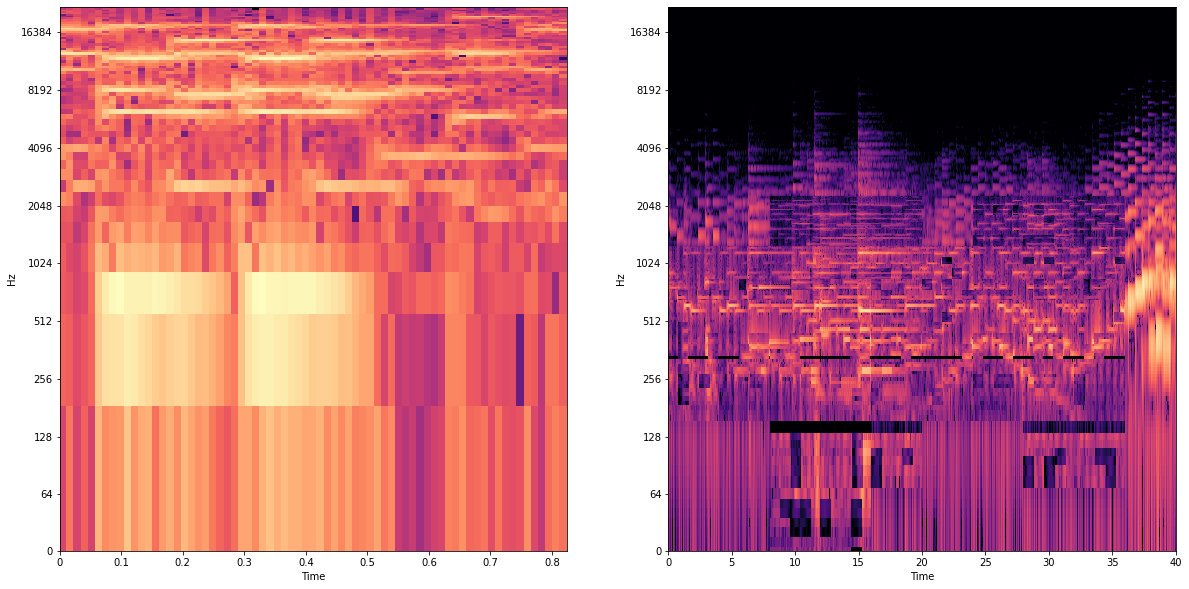

In [30]:
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(multires_spec_vis, ref=np.max), y_axis='log', x_axis='time', sr=sr)